### Project: Capstone Project 1: Data Story

While performing exploratory data analysis, I was able to organize and aggregate the data in such a way that I could apply multiple visualization techniques and gain more insight into the data to identify trends, correlations, and provide an initial story. Some of the questions I attempted to address in this notebook are:

    1. Ask the following questions and look for the answers using code and plots:
    
        a) Can you count something interesting?
        b) Can you find trends (e.g. high, low, increasing, decreasing, anomalies)?
        c) Can you make a bar plot or a histogram?
        d) Can you compare two related quantities?
        e) Can you make a scatterplot?
        f) Can you make a time-series plot?
           
    2. Looking at the plots, what are some insights you can make? 
       Do you see any correlations? 
       Is there a hypothesis you’d like to investigate further? 
       What other questions do the insights lead you to ask?

    3. Is there a narrative/way of presenting the insights using text and plots that tells a compelling story? 
       What are some other trends/relationships you think will make the story more complete?

In [1]:
import os
import numpy as np
import pandas as pd
import time
from datetime import datetime, timedelta
from dateutil import tz

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy import stats

sns.set(style="ticks", color_codes=True)

import warnings
warnings.filterwarnings('ignore')

In [2]:
# function to merge dataframes
def merge_dfs(basepath, years, pitchers, use_cols=[]):
    """
    iterate through list of pitchers of interest for each year in list to open play-by-play file
    then merge play-by-play data into a single dataframe
    
    returns merged dataframe
    """
    # path to pitcher_ids.csv file
    pitcher_ids_path = 'data/pitcher_logs/pitcher_ids.csv'
    # open pitcher_ids.csv file, set 'id' as index
    df_pitcher_ids = pd.read_csv(pitcher_ids_path, index_col='id')
    
    # list to store paths to each players play-by-play csv files
    filelist = []
    
    # iterate through list of pitchers for each year and gather file paths and pitcher names
    for year in years:
        for pitcher in pitchers:         
            file_path = basepath + '/' + year + '/merged_by_player/' + pitcher + '_' + year + '_merged_games.csv'
            f_name, l_name = pitcher.split(sep='_')
            filelist.append(file_path)
            
    # work with first pitcher in list to store in initial dataframe then remove pitcher from list
    first_file = filelist.pop(0)
    if len(use_cols)==0:
        df = pd.read_csv(first_file)
        ids = df['pitcher.id'].iloc[0]
        df['pitcher.first_name'] = df_pitcher_ids.at[ids, 'preferred_name']
        df['pitcher.last_name'] = df_pitcher_ids.at[ids, 'last_name']
    else:
        df = pd.read_csv(first_file, usecols=use_cols)
        ids = df['pitcher.id'].iloc[0]
        df['pitcher.first_name'] = df_pitcher_ids.at[ids, 'preferred_name']
        df['pitcher.last_name'] = df_pitcher_ids.at[ids, 'last_name']
    
    # work with remaining pitchers in list to concatenate data with previous dataframe
    for file in filelist:
        if len(use_cols)==0:
            # open merged_games.csv file for each player
            df_temp = pd.read_csv(file)
            ids = df_temp['pitcher.id'].iloc[0]
            df_temp['pitcher.first_name'] = df_pitcher_ids.at[ids, 'preferred_name']
            df_temp['pitcher.last_name'] = df_pitcher_ids.at[ids, 'last_name']
        else: # use only if specific columns requested
            # open merged_games.csv file for each player
            df_temp = pd.read_csv(file, usecols=use_cols)
            ids = df_temp['pitcher.id'].iloc[0]
            df_temp['pitcher.first_name'] = df_pitcher_ids.at[ids, 'preferred_name']
            df_temp['pitcher.last_name'] = df_pitcher_ids.at[ids, 'last_name']
            
        df = pd.concat([df, df_temp], ignore_index=True, sort=False)
    print("merge_dfs(...) completed.\n")
    return df

In [3]:
# function to aggregate pitch data
def aggegrate_df(df):
    """
    aggregate pitch types, pitch speed, and game details for each pitcher per year
    
    return dataframe with aggregated data
    """
    # path to pitcher_ids.csv file
    pitcher_ids_path = 'data/pitcher_logs/pitcher_ids.csv'
    # open pitcher_ids.csv file, set 'id' as index
    df_pitcher_ids = pd.read_csv(pitcher_ids_path, index_col='id')
    
    # list of pitch types expected
    list_of_pitches = ['FB','SL','CT','CB','CH','SF','KN','IB','PI','UN']
    # list to store dictionary of pitch data for each pitcher
    list_of_dicts = []
    # iterate through each pitcher and aggregate pitch data
    for ids in df_pitcher_ids.index:
        # collect pitchers name
        first_name = df_pitcher_ids.at[ids, 'preferred_name']
        last_name = df_pitcher_ids.at[ids, 'last_name']
        # iterate through each year
        for yrs in df.year.unique():
            # list to store pitch counts, pitch percentages, and pitch speeds
            pitch_counts = [0] * 10
            pitch_prcnts = [0.0] * 10
            pitch_speeds = [0.0] * 10
            # select specific pitcher for specific year
            df_pitcher = df[(df['pitcher.id']==ids) & (df['year']==yrs)]
            # store whether pitcher is left or right handed
            handedness = df_pitcher['pitcher.pitcher_hand'].iloc[0]
            # store the number of pitches the pitcher threw each year
            pitches = int(df_pitcher.year.count())
            # store the number of games each pitcher started each year
            games = int(df_pitcher.groupby(['year', 'month', 'day'])['day'].count().count())
            # store the number of innings each pitcher threw at least 1 pitch each year
            innings  = int(df_pitcher.groupby(['year', 'month', 'day', 'pitcher.id'])['inning'].agg('max').sum())
            
            # calculate that average number of pitches per game, per inning, and innings per game
            pitches_gs = pitches / games
            ip_gs = innings / games
            pitches_ip = pitches / innings
            
            # get the number each pitch type was thrown per year and average pitch speeds
            df_pTypes = df_pitcher.groupby(['year', 'pitcher.pitch_type'])['pitcher.pitch_speed'].agg(['count', 'mean'])
            # iterate through each pitch type and compute number, percent, and speed of pitch types
            for idx, pitch in enumerate(list_of_pitches):
                if pitch in df_pTypes.T[yrs].columns:
                    pitch_counts[idx] = int(df_pTypes.T[yrs][pitch][0])
                    pitch_prcnts[idx] = round((pitch_counts[idx]/pitches)*100, 2)
                    pitch_speeds[idx] = round(float(df_pTypes.T[yrs][pitch][1]), 2)
            # store values in dictionary
            dict_cols = {'Year':yrs, 'First_name':first_name, 'Last_name':last_name, 
                         'Handedness':handedness, 'GS':games, 'IP':innings, 'Pitches':pitches, 
                         'Pitches/GS': pitches_gs, 'IP/GS': ip_gs, 'Pitches/IP': pitches_ip, 
                         'FB': pitch_counts[0], 'SL': pitch_counts[1],'CT': pitch_counts[2],
                         'CB': pitch_counts[3], 'CH': pitch_counts[4],'SF': pitch_counts[5],
                         'KN': pitch_counts[6], 'IB': pitch_counts[7],'PI': pitch_counts[8],
                         'UN': pitch_counts[9], 'FB%': pitch_prcnts[0],'SL%': pitch_prcnts[1],
                         'CT%': pitch_prcnts[2], 'CB%': pitch_prcnts[3],'CH%': pitch_prcnts[4],
                         'SF%': pitch_prcnts[5], 'KN%': pitch_prcnts[6],'IB%': pitch_prcnts[7],
                         'PI%': pitch_prcnts[8], 'UN%': pitch_prcnts[9], 'FB_spd': pitch_speeds[0], 
                         'SL_spd': pitch_speeds[1],'CT_spd': pitch_speeds[2], 'CB_spd': pitch_speeds[3], 
                         'CH_spd': pitch_speeds[4],'SF_spd': pitch_speeds[5], 'KN_spd': pitch_speeds[6], 
                         'IB_spd': pitch_speeds[7],'PI_spd': pitch_speeds[8], 'UN_spd': pitch_speeds[9]}
            # append dictionary to list of dictionaries
            list_of_dicts.append(dict_cols)
    # create new dataframe from list of dictionaries       
    df_new = pd.DataFrame(list_of_dicts)
    
    print("aggegrate_df(...) completed.\n")
    return df_new

In [4]:
# base path with subfolders for each pitcher of interest
basepath = 'data/pbp_files'

# list of years to clean and merge play-by-play data
years = ['2016', '2017', '2018']

# list of pitchers of interest
pitchers = ['aaron_nola', 'carlos_carrasco', 'carlos_martinez', 'chris_archer', 'chris_sale', 
            'clayton_kershaw', 'corey_kluber', 'dallas_keuchel', 'david_price', 'gerrit_cole',
            'jacob_degrom', 'jake_arrieta', 'jose_quintana', 'marcus_stroman', 'justin_verlander', 
            'max_scherzer', 'michael_fulmer', 'stephen_strasburg', 'yu_darvish', 'zack_greinke']

In [5]:
# general list of similar columns grouped for pitchers of interest dataframe
count_cols = ['count.balls', 'count.strikes', 'count.outs', 'count.pitch_count']
pitch_cols = ['pitcher.pitch_type', 'pitcher.pitch_speed', 'pitcher.pitch_count', 'outcome_id']
flags_cols = ['flags.is_ab_over']
pitcher_cols = ['pitcher.first_name', 'pitcher.last_name', 'pitcher.pitcher_hand', 
                'pitcher.hitter_hand', 'pitcher.id']
runner_cols = ['runner_1.starting_base', 'runner_1.ending_base', 'runner_1.outcome_id', 
               'runner_2.starting_base', 'runner_2.ending_base', 'runner_2.outcome_id', 
               'runner_3.starting_base', 'runner_3.ending_base', 'runner_3.outcome_id', 
               'runner_4.starting_base', 'runner_4.ending_base', 'runner_4.outcome_id']
date_cols = ['year', 'month', 'day']
inning_cols = ['inning', 'half']

In [6]:
# call to merge play-by-play data into single dataframe for player's of interest (poi)
df_merged = merge_dfs(basepath, years, pitchers)
# rename some pitch types that are too similar to distinguish 
# such as sinkers -> fastball, split-finger curve -> curveball, and forkball -> splitter
df_merged.replace({'FA': 'FB', 'SI': 'FB', 'CU': 'CB', 'SC': 'CB', 'SP': 'SF', 'FO': 'SF'}, inplace=True)

merge_dfs(...) completed.



## 1. Ask the following questions and look for the answers using code and plots:

    a) Can you count something interesting?
    b) Can you find trends (e.g. high, low, increasing, decreasing, anomalies)?
    c) Can you make a bar plot or a histogram?
    d) Can you compare two related quantities?
    e) Can you make a scatterplot?
    f) Can you make a time-series plot?

### 1 a. Count Something Interesting

Count various data points such as:
    * pitches thrown per season
    * games started per season
    * innings pitched
    * percent of pitch types thrown    

In [7]:
# aggregate pitch data for pitchers of interest (poi)
df = aggegrate_df(df_merged)

aggegrate_df(...) completed.



In [8]:
# concatenate the first and last name of pitcher then drop the separate columns
df['Name'] = df['First_name'].str.cat(df['Last_name'], sep=' ')
df.drop(columns=['First_name', 'Last_name'], inplace=True)

#### Using the dataframe with agggregate data, I am able to:

* count the total number of games each pitcher started (gs) in 2016, 2017, and 2018
* count the number of innings pitched (ip) by each pitcher
* count the total number pitches each pitcher threw in 2016, 2017, and 2018
* compute the average 
    - innings pitched per game (ip/gs)
    - pitches thrown per game (pitches/gs)
    - pitches thrown per inning (pitches/ip)  

In [9]:
# show some interesting values for each pitcher per year
df[['Year', 'Name', 'GS', 'IP', 'Pitches', 'IP/GS', 'Pitches/GS', 'Pitches/IP']].head()

,Year,Name,GS,IP,Pitches,IP/GS,Pitches/GS,Pitches/IP
0,2016,Aaron Nola,20,114,1800,5.700000,90.000000,15.789474
1,2017,Aaron Nola,27,171,2666,6.333333,98.740741,15.590643
2,2018,Aaron Nola,33,217,3217,6.575758,97.484848,14.824885
3,2016,Carlos Carrasco,25,154,2250,6.160000,90.000000,14.610390
4,2017,Carlos Carrasco,32,209,3063,6.531250,95.718750,14.655502


#### Observations:

* When healthy, starting pitchers average about **30** starts per year.
* Starting pitchers also pitch in approximately **200** innings per year.
* Not often, a starting pitcher completes a game (pitches 9 innings). Most make it only to the **6-7th** inning before getting pulled for relief pitcher.
* Startig pitchers can be expected to pitch around **100** pitches a game with an average of **15** pitches per inning.

**Note**: Not included in this notebook, however, I can also count the number of Balls and Strikes pitched per hitter, per inning, per pitcher, per year. More interestingly, I can also evaluate the different pitch types based on inning, game, year, and previous outcome, such as thrown strike, thrown ball, foul ball, swinging or looking strike, base hit, homerun, walk, and when runner(s) is on base just to name a few.

-------------------------------

-----------------
To assure that the **20 selected pitcher's of interest (POI)** are a good representation of all pitchers in the MLB, I opted to collect pre-aggregated statistics from https://www.baseball-reference.com/ for all starting pitchers for the past 9 regular seasons (2010-2018), to compare to the selected 20 POI's.

* **Goal is to show that my 20 selected POI's and other MLB Starters average approximately the same number of:** 
    - Innings pitched per game
    - Pitches thrown per game
    - Pitches thrown per inning

In [10]:
# path to 2010-2018 MLB starting pitcher stats provided by baseball-reference.com
# stats aggregated per season for starting pitchers with 20 or more games started
fangraph_path = 'data/fangraphs/fangraphs_2010_to_2018_stats.csv'

In [11]:
# open fangraphs MLB stats file
df_fangraph = pd.read_csv(fangraph_path, index_col='Year')

In [12]:
# select specific columns and apply 'group' tag to fangraph data
df_fg = df_fangraph[['IP/GS', 'Pitches/GS', 'Pitches/IP']]
df_fg.reset_index(inplace=True)
df_fg['Group'] = 'Fangraph'

In [13]:
# select specific columns and apply 'group' tag to pitchers of interest data
df_poi = df.groupby(['Year'])['IP/GS', 'Pitches/GS', 'Pitches/IP'].agg('mean')
df_poi.reset_index(inplace=True)
df_poi['Group'] = 'POI'

In [14]:
# append the pitchers of interest and fangraph data into single dataframe
df_mrg = df_fg.append(df_poi, ignore_index=True)
# format combined dataframe to compare to pitchers of interest with fangraph data
df_ipgs = df_mrg[['Year', 'IP/GS', 'Group']]
df_pgs = df_mrg[['Year', 'Pitches/GS', 'Group']]
df_pip = df_mrg[['Year', 'Pitches/IP', 'Group']]
# rename columns so they will merge when appended
df_ipgs.rename(columns={'IP/GS':'Percent'}, inplace=True)
df_pgs.rename(columns={'Pitches/GS':'Percent'}, inplace=True)
df_pip.rename(columns={'Pitches/IP':'Percent'}, inplace=True)
# include 'type' column to be used in lineplot as 'hue' variable
df_ipgs['Type'] = 'Innings/Game'
df_pgs['Type'] = 'Pitches/Game'
df_pip['Type'] = 'Pitches/Inning'

df_tmp = df_ipgs.append(df_pgs, ignore_index=True)
df_mrg_final = df_tmp.append(df_pip, ignore_index=True)

Text(0.5,1,'20 Pitchers of Interest (Group: POI) 2016-2018 vs.\n All Starting Pitchers (Group: Fangraph) 2010-2018')

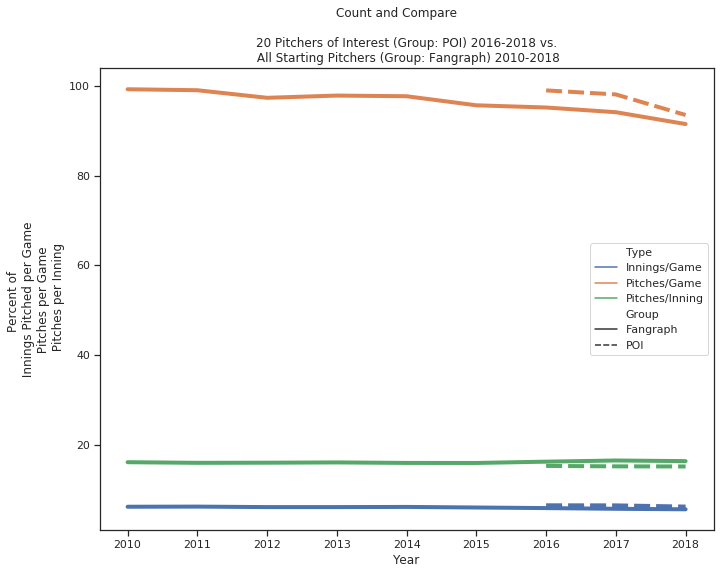

In [15]:
# set figure dimensions
a4_dims = (11, 8.5)
fig, ax = plt.subplots(figsize=a4_dims)

# use lineplot to compare number of Games, Innings, and Pitches for POI's and other starting MLB pitchers
ax = sns.lineplot(x="Year", y="Percent", hue='Type', data=df_mrg_final, style='Group', lw=4)
plt.xlabel('Year')
plt.ylabel('Percent of \n Innings Pitched per Game \n Pitches per Game \n Pitches per Inning')
plt.suptitle('Count and Compare')
plt.title('20 Pitchers of Interest (Group: POI) 2016-2018 vs.\n All Starting Pitchers (Group: Fangraph) 2010-2018')

#### Observations:

* The number of Innings Pitched and Pitches Thrown by my **20 Selected Pitchers of Interest** are comparable to those of **all starting MLB pitchers** for **2016**, **2017**, and **2018**.
* The lineplot indicates that the **20 POI's** tend to throw more pitches per game, however, this could also be due to them also pitching in slightly more innings per game on average.

### 1 b. Identify trends (e.g. high, low, increasing, decreasing, anomalies)

Pitch Type Key:
    - FB = Fastball
    - SL = Slider
    - CT = Cutter
    - CB = Curveball
    - CH = Change-up
    - SF = Split-finger
    - KN = Knuckleball

In [16]:
# list of columns for pitch type percentages and pitch type speeds
percent_cols = ['FB%', 'SL%', 'CT%', 'CB%', 'CH%', 'SF%', 'KN%']
speed_cols = ['FB_spd', 'SL_spd', 'CT_spd', 'CB_spd', 'CH_spd', 'SF_spd', 'KN_spd']

In [17]:
# dataframe for pitch types for pitchers of interest
df_poi_pTypes = df[percent_cols + speed_cols + ['Year', 'Handedness', 'Name']].copy()

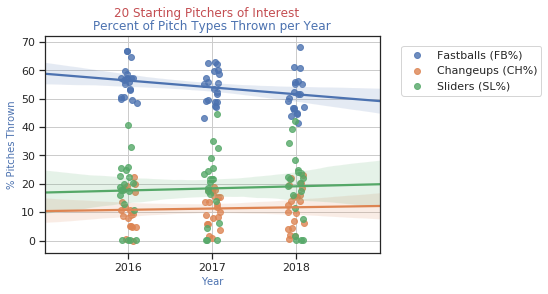

In [18]:
# regression plot to show trends for Fastballs, Sliders, and Changeups over the past 3 years 
ax = sns.regplot(x='Year', y='FB%', data=df_poi_pTypes, x_jitter=0.1, label='Fastballs (FB%)')
ax = sns.regplot(x='Year', y='CH%', data=df_poi_pTypes, x_jitter=0.1, label='Changeups (CH%)')
ax = sns.regplot(x='Year', y='SL%', data=df_poi_pTypes, x_jitter=0.1, label='Sliders (SL%)')
ax.legend(bbox_to_anchor=(1.5, .7), loc="lower right")

# extend the x-axis beyond 2016 and 2018
plt.xlim(2015, 2019) 
# show only 2016, 2017, and 2018 on x-axis
plt.xticks([2016, 2017, 2018]) 

# set the title of the plot
plt.suptitle('20 Starting Pitchers of Interest', fontsize=12,color="r",alpha=1)
plt.title('Percent of Pitch Types Thrown per Year', fontsize=12,color="b",alpha=1)
# set the xlabel of the plot
plt.xlabel("Year",size = 10,color="b",alpha=1)
# set the ylabel of the plot
plt.ylabel("% Pitches Thrown",size = 10,color="b",alpha=1)
plt.grid()

#### Observations:

* The percentage of Fastballs (FB) appear to be decreasing over the past 3 years (2016-2018).
* The percentage of Sliders (CT) and Changeups (CH), however, appear to be increasing over the same time span.

-----------------
To see if the **20 selected pitcher's of interest (POI)** trend also appears for all starting pitchers in the MLB, I plotted the same graph using pitch type percentages collected from baseball-reference.com for the same years (2016-2018).

**Goal is to see if the percent of Fastballs, Sliders, and Changeups follow the same trends.** 


In [19]:
# path to 2010-2018 MLB starting pitcher pitch stats provided by baseball-reference.com
fangraph_pitch_path = 'data/fangraphs/fangraphs_2010_to_2018_pitch_prcnts.csv'

In [20]:
# open fangraphs MLB stats file and grab only years 2016, 2017, and 2018 for comparison
df_fangraph = pd.read_csv(fangraph_pitch_path, index_col='Year')
df_fangraph_pitches = df_fangraph[df_fangraph.index.isin(['2016', '2017', '2018'])]

In [21]:
df_fangraph_pitches.reset_index(inplace=True)

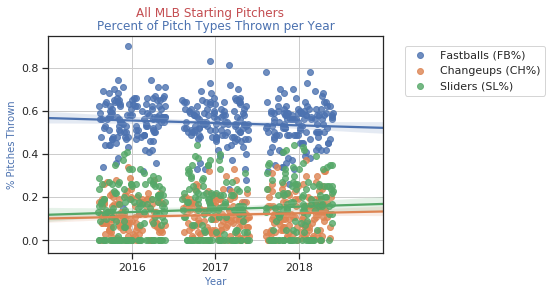

In [22]:
# regression plot to show trends for Fastballs, Sliders, and Changeups over the past 3 years 
ax = sns.regplot(x='Year', y='FB%', data=df_fangraph_pitches, x_jitter=0.4, label='Fastballs (FB%)')
ax = sns.regplot(x='Year', y='CH%', data=df_fangraph_pitches, x_jitter=0.4, label='Changeups (CH%)')
ax = sns.regplot(x='Year', y='SL%', data=df_fangraph_pitches, x_jitter=0.4, label='Sliders (SL%)')
ax.legend(bbox_to_anchor=(1.5, .7), loc="lower right")

# extend the x-axis beyond 2016 and 2018
plt.xlim(2015, 2019) 
# show only 2016 - 2018 on x-axis
plt.xticks([2016, 2017, 2018]) 

# set the titles of the plot
plt.suptitle('All MLB Starting Pitchers', fontsize=12,color="r",alpha=1)
plt.title('Percent of Pitch Types Thrown per Year', fontsize=12,color="b",alpha=1)
# set the xlabel of the plot
plt.xlabel("Year",size = 10,color="b",alpha=1)
# set the ylabel of the plot
plt.ylabel("% Pitches Thrown",size =10,color="b",alpha=1)
plt.grid()

#### Observations:

* The percentage of Fastballs (FB) continue to appear to be **decreasing** over the past 3 years (2016-2018).
* The percentage of Changeups (CH) and Sliders (SL) also appear to be **increasing** over the same time span.
* It is possible that this trend is due to **changes/improvements in the pitch classification system**.

    * **Sliders** are breaking pitches that are thrown with less velocity than Fastballs but faster than Curveballs.
        - It is possible that Fastballs and/or Curveballs are now being **more accurately classified** as Sliders, thus the **increase**.
-------------------------

-----------------
#### A final look at the Percent of Fastballs thrown by each of the 20 Starting Pitchers of Interest over the last 3 years (2016-2018)

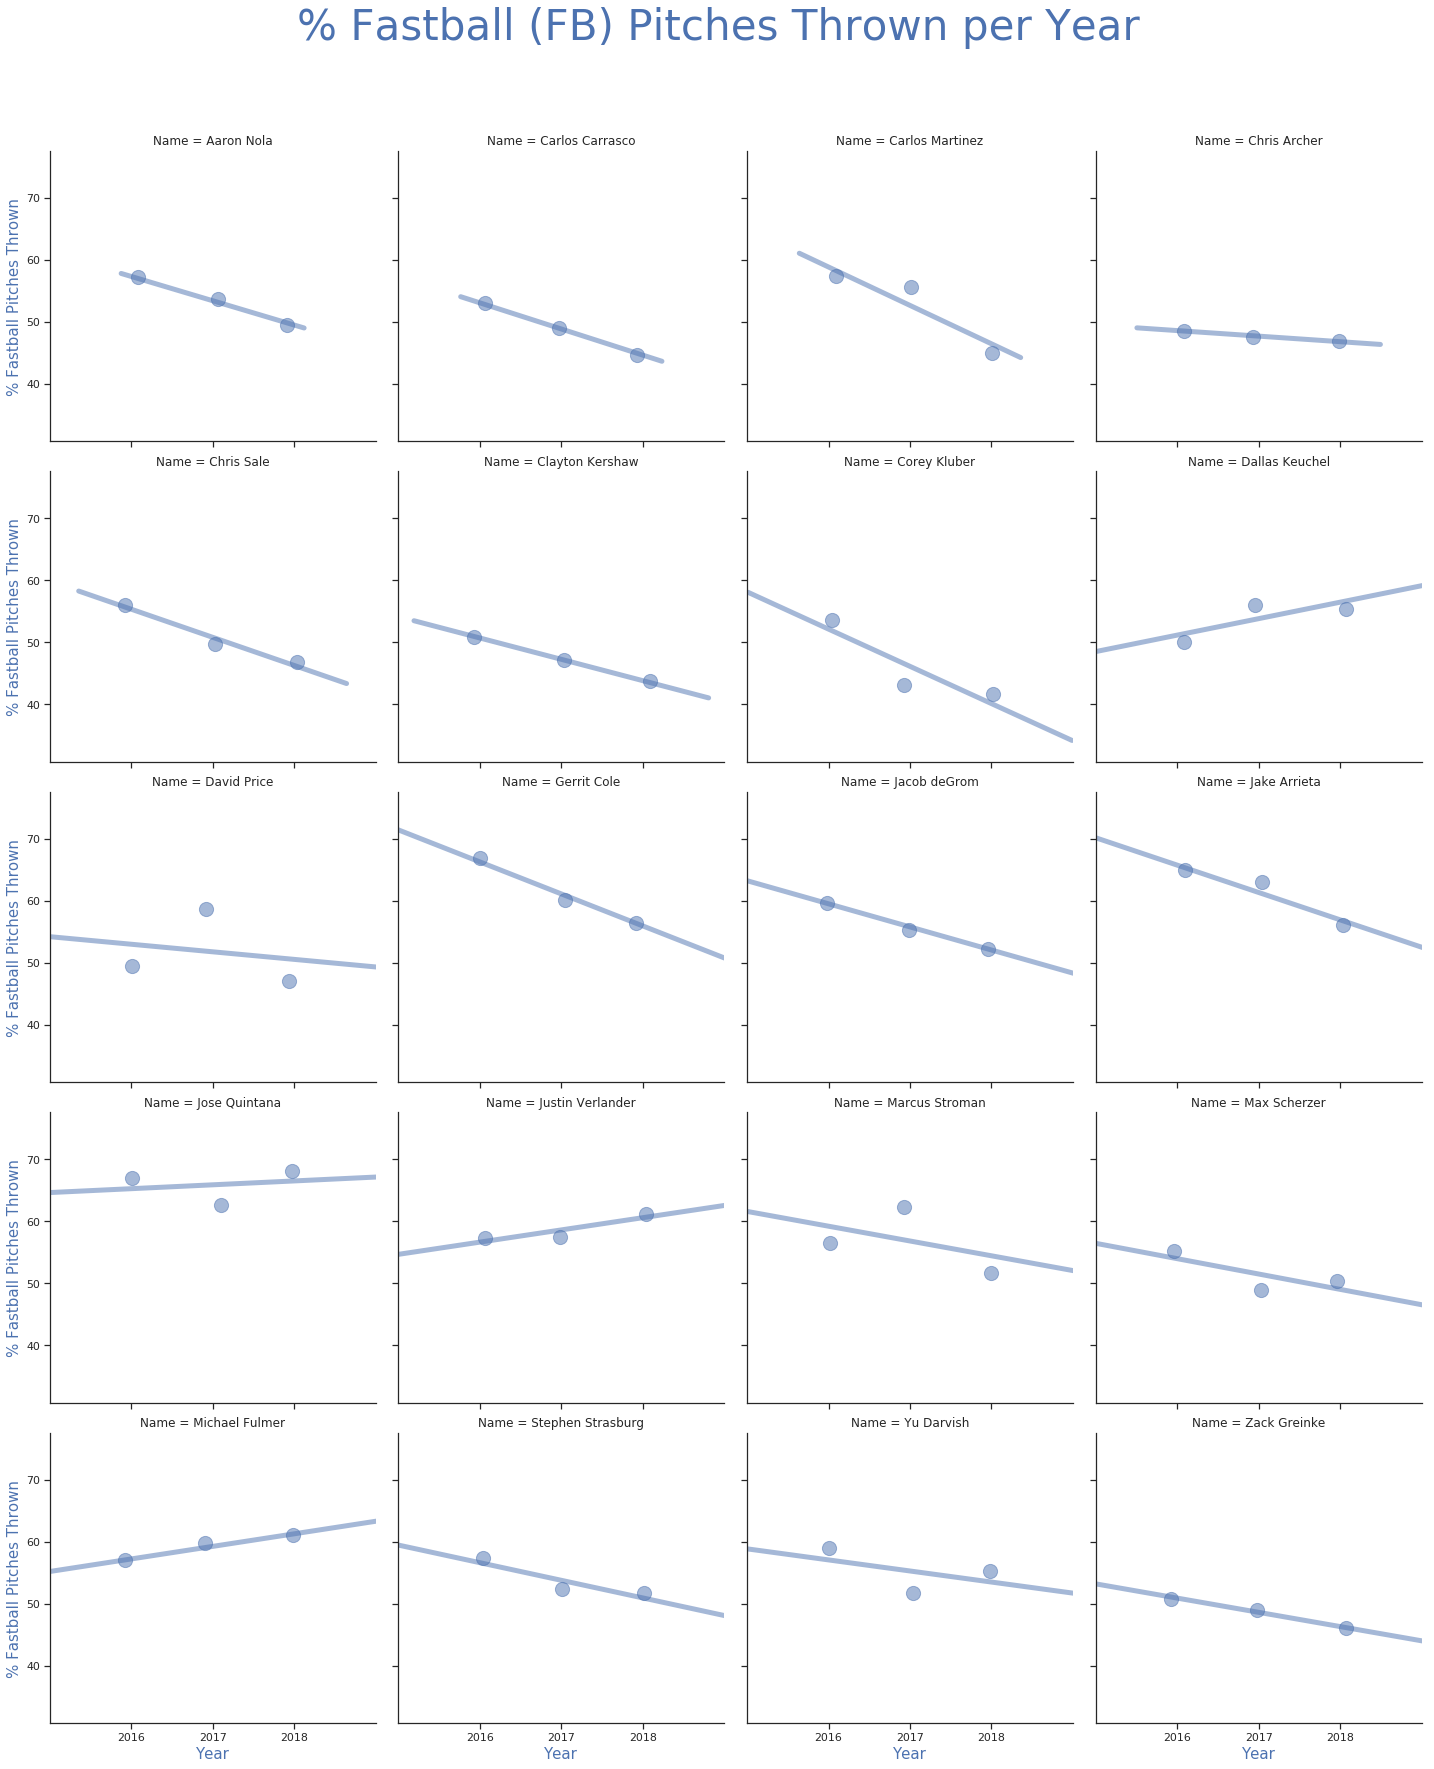

In [23]:
# 2D scatterplot to illustrate percent of Fastballs thrown with an overlaid regression line 
g = sns.lmplot(x="Year", y="FB%",ci=None, data=df_poi_pTypes, col="Name",
    palette="muted",col_wrap=4,scatter_kws={"s": 200,"alpha":0.5},
    line_kws={"lw":5,"alpha":0.5, }, x_jitter=.1,y_jitter=.1,height=5)
plt.xlim(2015, 2019)
plt.xticks([2016, 2017, 2018])

# additional line to adjust some appearance issue
plt.subplots_adjust(top=.9)

# set the title of the plot
g.fig.suptitle('% Fastball (FB) Pitches Thrown per Year', fontsize=42,color="b",alpha=1)
# set the xlabel of the plot
g.set_xlabels("Year",size = 15,color="b",alpha=1)
# set the ylabel of the plot
g.set_ylabels("% Fastball Pitches Thrown",size = 15,color="b",alpha=1)

#### Observations:

* The percentage of Fastballs (FB) for 16 of the 20 pitchers of interest appear to be **decreasing** over the past 3 years (2016-2018).
* Only Dallas Keuchel, Jose Quintana, Justin Verlander, and Michael Fulmer show an increasing percent of Fastball pitches thrown since 2016. 
    * Interestingly, Dallas Keuchel and Justin Verlander played for the same team (Astros) for part of 2017 and all of 2018.
    * However, Gerrit Cole also played for the Astros in 2018 but shows a decrease in Fastballs.
* All pitchers throw Fastballs but not all pitchers throw Sliders, Split-finger Curve or Fastballs, or Cutters and Knuckleballs.
    - It is **most likely** that Fastballs are getting classified as other pitch types with more accuracy.
    - **Less likely** that pitchers are choosing to throw the Fastball less over time.

**NOTE**: It will be very interesting to also check possible trends in **Pitch Speeds** over time (Games in a Season, Innings in a Game, and Seasons). As pitchers throw more pitches over time, they may tire which in turn can impact a pitchers decision on which pitch to throw.

-------------------------

### 1 c / d. Create a Bar Plot or Histogram / Compare Two or More Related Quantities

In [24]:
# drop unneeded columns to compare pitch type percentages and pitch speeds
df_res = df_poi_pTypes.drop(columns=['Name', 'Handedness'])

In [25]:
# reformt the dataframe to graph bar plot and compare pitch type percentages for 2016-2018
df_FB = df_res[['Year', 'FB%', 'FB_spd']]
df_FB.rename(columns={'FB%':'Percent', 'FB_spd':'Pitch_speed'}, inplace=True)
df_FB['Pitch_type'] = 'FB'
df_SL = df_res[['Year', 'SL%', 'SL_spd']]
df_SL.rename(columns={'SL%':'Percent', 'SL_spd':'Pitch_speed'}, inplace=True)
df_SL['Pitch_type'] = 'SL'
df_CT = df_res[['Year', 'CT%', 'CT_spd']]
df_CT.rename(columns={'CT%':'Percent', 'CT_spd':'Pitch_speed'}, inplace=True)
df_CT['Pitch_type'] = 'CT'
df_CB = df_res[['Year', 'CB%', 'CB_spd']]
df_CB.rename(columns={'CB%':'Percent', 'CB_spd':'Pitch_speed'}, inplace=True)
df_CB['Pitch_type'] = 'CB'
df_CH = df_res[['Year', 'CH%', 'CH_spd']]
df_CH.rename(columns={'CH%':'Percent', 'CH_spd':'Pitch_speed'}, inplace=True)
df_CH['Pitch_type'] = 'CH'

df_tmp1 = df_FB.append(df_SL, ignore_index=True)
df_tmp2 = df_tmp1.append(df_CT, ignore_index=True)
df_tmp3 = df_tmp2.append(df_CB, ignore_index=True)
df_final = df_tmp3.append(df_CH, ignore_index=True)

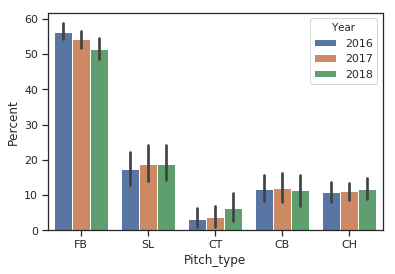

In [26]:
# plot bar plot for Fastballs (FB), Sliders (SL), Cutters (CT), Curveballs (CB), and Changeups (CH)
_ = sns.barplot(x='Pitch_type', y='Percent', hue='Year', data=df_final)

#### Observations:

* We continue to see that more than half of all pitches thrown are Fastballs (FB).
    * This would indicate that a hitter can expect a Fastball to be thrown more than 50% of the time when at bat.
* Sliders (SL), Cutters (CT), Curveballs (CB), and Changeups (CH) are fairly even.
-------------------------

### 1 e. Make a Scatterplot

Plot the Percent of Pitch Types thrown VS. Pitch Type Speeds

In [27]:
# exclude rows where the percent of pitch types or pitch speeds are zero
df_revised = df_final[(df_final['Percent']!=0) & (df_final['Pitch_speed']!=0)]

Text(0.5,1,'Percentage vs. Speed')

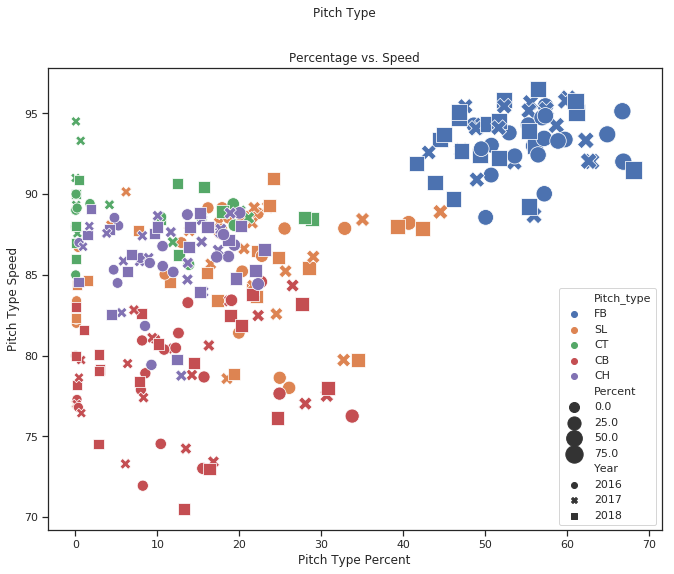

In [28]:
# set figure dimensions
a4_dims = (11, 8.5)
fig, ax = plt.subplots(figsize=a4_dims)

# scatter plot for pitch type percentage thrown versus pitch speed
ax = sns.scatterplot(x="Percent", y="Pitch_speed", hue="Pitch_type", style='Year', 
                     size="Percent", sizes=(100,300), data=df_revised)
plt.xlabel('Pitch Type Percent')
plt.ylabel('Pitch Type Speed')
plt.suptitle('Pitch Type')
plt.title('Percentage vs. Speed')

#### Observations:

* While it may appear that Fastballs (FB) cluster clearly based only on speed, this scatterplot actually supports the difficulty in classifying pitches accurately.
    * Cutters (CT) are technically Fastballs (just a little slower) with more break.
        * To see Cutters with a velocity near 95 MPH indicates that it may have been mis-classified.
        * Such Cutters were also classified as such in 2017 (before system improvements), thus supporting mis-classification.
* Speed alone cannot properly classify pitch types. It is necessary to also consider:
    * X and Y Movement
    * Spin rate
    * Location

---------

### 1 f. Make a Time-Series Plot

A MLB regular season generally lasts from April - Sep/Oct. As the season progresses, it would be interesting to see if pitch selection differs from the start of the season to the end.
    * To illustrate this, I used a time-series plot with the percent of pitch types thrown per month per year.

Also, as a single game progresses, a pitcher can get fatigued. While most pitcher's only pitch the first 6-7 innings, it will be interesting to see if pitch selection varies in the later innings, including extra innings (>9).
    * To illustrate this, I used a time-series plot with the percent of pitch types thrown per inning.

#### Pitches per Month-Year

In [29]:
# dictionary of columns that need to be renamed
rename_dict = {'pitcher.pitch_type':'Pitch_type', 'pitcher.pitch_speed':'Pitch_speed', 
               'year': 'Year', 'month': 'Month', 'inning':'Inning'}
# select pitch types to plot per month per year
df_rev = df_merged[df_merged['pitcher.pitch_type'].isin(['FB','SL','CT','CB','CH'])]
df_rev.rename(columns=rename_dict, inplace=True)

In [30]:
# count the number of pitch types per month
df_pTypes = df_rev.groupby(['Year', 'Month', 'Pitch_type'])['Pitch_type'].agg(['count'])

In [31]:
# reset index and combine the Year and Month into a single datetime column
df_pTypes.reset_index(inplace=True)
df_pTypes['Date'] = pd.to_datetime(df_pTypes['Month'].map(str) + '/' + df_pTypes['Year'].map(str))
df_pTypes.drop(columns=['Year', 'Month'], inplace=True)

In [32]:
# calculate the percent of each pitch types thrown per month per year
df_pTypes_final = df_pTypes.groupby(['Date', 'Pitch_type']).sum()/df_pTypes.groupby(['Date']).agg('sum')
df_pTypes_final.reset_index(inplace=True)

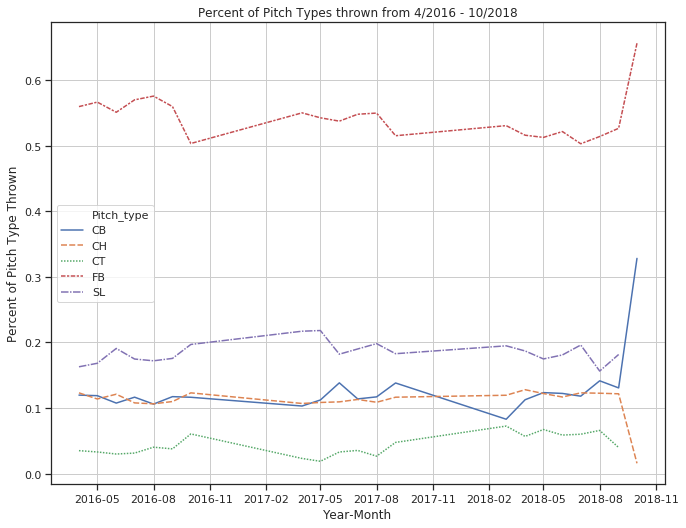

In [33]:
# set figure dimensions
a4_dims = (11, 8.5)
fig, ax = plt.subplots(figsize=a4_dims)

# plot line plot with percent of pitch types thrown per month per year
ax = sns.lineplot(x="Date", y="count", hue='Pitch_type', data=df_pTypes_final, style='Pitch_type')
plt.xlabel('Year-Month')
plt.ylabel('Percent of Pitch Type Thrown')
plt.title('Percent of Pitch Types thrown from 4/2016 - 10/2018')
plt.grid()

#### Observations:

* It is interesting to see that from August - October, the percent of Fastballs (FB) thrown decreases with the exception of 2018 where it begins to decrease sooner only to jump up significantly in Sept.
* This is most likely due to additional single game elimination play-off games that were played in October as a tie breaker (not common).
    * One or two pitchers may have caused the **anomaly**.

#### Pitches per Inning

In [34]:
# count the number of pitch types per inning
df_pTypes2 = df_rev.groupby(['Inning', 'Pitch_type'])['Pitch_type'].agg(['count'])
df_pTypes2.reset_index(inplace=True)

In [35]:
# calculate the percent of each pitch types thrown per inning
df_pTypes2_final = df_pTypes2.groupby(['Inning', 'Pitch_type']).sum()/df_pTypes2.groupby(['Inning']).agg('sum')
df_pTypes2_final.reset_index(inplace=True)

Text(0.5,1,'Percent of Pitch Types thrown per Inning from 4/2016 - 10/2018')

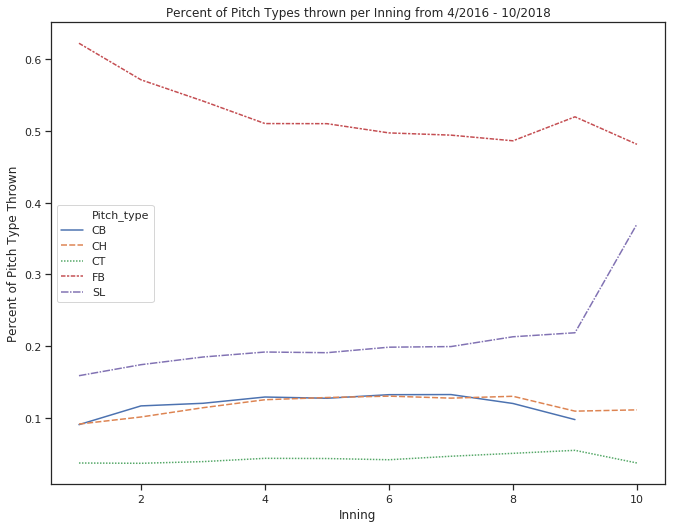

In [36]:
# set figure dimensions
a4_dims = (11, 8.5)
fig, ax = plt.subplots(figsize=a4_dims)

# plot line plot with percent of pitch types thrown per inning
ax = sns.lineplot(x="Inning", y="count", hue='Pitch_type', style='Pitch_type', data=df_pTypes2_final, legend='full')
plt.xlabel('Inning')
plt.ylabel('Percent of Pitch Type Thrown')
plt.title('Percent of Pitch Types thrown per Inning from 4/2016 - 10/2018')

#### Observations:

* As exected, the percent of Fastballs (FB) thrown decreases as the game progresses.
* What wasn't expected was that the decrease happens rapidly from inning 1-3 and leveling off around 50% from innings 4-6.
* There is a little jump at inning 9 which actually makes sense considering if the starting makes it to this point, they are attempting to complete the game and are probably winning, thus giving it all they got to end the game.

## 2. Looking at the plots, what are some insights you can make? 
    a) Do you see any correlations?
    b) Is there a hypothesis you’d like to investigate further? 
    c) What other questions do the insights lead you to ask?

---------

### 2. Insights

a) **Correlations**
    * When reviewing the time-series plot for pitch types per inning, it is obvious to see a correlation between Fastball percentage and inning. As innings increase, Fastballs decrease.
b) **Hypothesis**
    * I would like to investigate a hypothesis that previous outcome impacts the next pitch type
        - Previous outcomes include if last batter:
            * got a hit
            * strike out
            * get homerun
            * walk
        - Also current batter outcomes such as:
            * swinging strike
            * looking strike
            * foul ball
            * bunt attempt
    * More so than inning, score, and base runners, the previous outcomes impact next pitch the most.
c) **Questions / Insights**
    * In addition to the hypothesis that outcomes have a major impact on pitch type, I think it would be interesting to look at the following for possible correlations with pitch types:
        - Runners on base
        - Current score
        - Hitter handedness (left or right batter)
    * If possible, I would also like to consider pitch location as an added feature to go along with pitch type.

## 3. Best way of presenting the insights using text and plots that tells a compelling story? 

What are some other trends/relationships you think will make the story more complete?

I think the first part of the story needs to briefly cover general rules and gameplay which includes basic terminology. This can be done with some text and bullet points in a slide or two. To emphasize the importance of assisting hitters and why it is important to predict the next pitch, a slide or two illustrating how MLB attendance and TV ratings continue to drop and the number of base hits and hitting percentages decrease while the number of strikeouts increases. As with most sports, the more action and scoring, the higher the attendance and ratings. 

I feel it is also important to illustrate the similarities and differences between pitch types. There are basically two types of pitches, fastball and breaking pitches. To throw hitters off, these pitches are varied based on speed, movement, and location. For instance, a cutter, is a type of fastball that breaks toward the pitcher's glove-hand side, as it reaches home plate. This pitch is somewhere between a slider and a two-seam fastball, as it is usually thrown faster than a slider but with more motion than a typical fastball. This will hopefully help explain why it is so difficult to classify pitch types and why hitters also only average between 2.5 to 3.5 hits for every 10 at bats for their entire career. This would be best illustrated with pictures on 1-2 slides.

For simplicity, it made sense to group pitch data and aggregate their pitch types to visualize it, however, moving forward, I believe each pitcher must be assessed and presented individually since some pitchers like Justin Verlander tend to throw faster as the game progresses and others throw slower curveballs with more movement in later innings.

Most pitchers, when a runner is on base, change their pitching stance, allowing them an attempt at throwing the runner out. This can also impact their pitch selection as well, since Fastballs get to the catcher sooner and increase the odds for the catcher to throw out a runner stealing a base. However, some pitchers choose not to change their stance (so as to not impact their pitch location and speed) and essentially allow a runner to steal base also having no problem throwing slower curvaballs or changeups.

Once the story is complete, I expect to have a visual presentation showing pitcher trends and relationships between hitter outcomes / current game status and pitch type selections. 